<a href="https://colab.research.google.com/github/soumitrapy/DeptEst/blob/main/playbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !git clone -b dev https://github.com/soumitrapy/DeptEst.git project
# %cd project
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip -q '/content/drive/MyDrive/Colab Notebooks/ee5179.zip'

fatal: destination path 'project' already exists and is not an empty directory.
/content/project
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace competition-data/create_spc.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace competition-data/imgs2csv.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace competition-data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace competition-data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [1]:
%matplotlib inline

In [3]:
import yaml
config = yaml.safe_load(open("config/default.yaml"))
config

{'project': 'DeptEst',
 'use_wandb': False,
 'dataset': {'name': 'CustomDataset',
  'root': './competition-data',
  'training-images': 'training-images',
  'training-depths': 'training-depths',
  'validation-images': 'validation-images',
  'validation-depths': 'validation-depths',
  'testing-images': 'testing-images',
  'img_size': 256,
  'batch_size': 10},
 'model': {'name': 'UNet', 'filters': [1, 4, 8, 16, 32, 64]},
 'train': {'epochs': 10, 'val_interval': 1}}

In [4]:
config['dataset']['batch_size']=10
config['train']['epochs']=1
#config['use_wandb']=True
config['model']['filters'] = [1, 32, 32, 64, 64, 128]
# a4ae227b893b7695d766727c3f4d4e630f69ce16
import wandb
if config.get('use_wandb',False):
    wandb.login()

In [5]:
from torchvision import transforms
from preprocessing import get_datasets_and_dataloaders

ds, dl = get_datasets_and_dataloaders(config)
ds, dl
for x,y in dl['train']:
    print(x.shape, y.shape)
    break

torch.Size([10, 1, 256, 256]) torch.Size([10, 1, 256, 256])


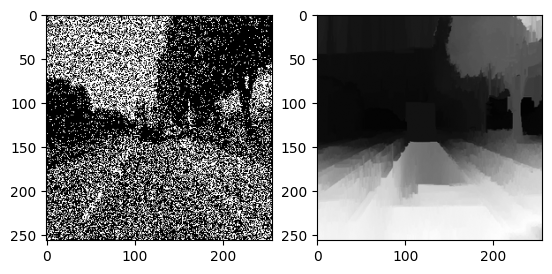

In [6]:
import numpy as np
import utils

idx = np.random.randint(len(ds['train']))
utils.show_images(idx = np.random.randint(len(ds['train'])), ds=ds['train'])

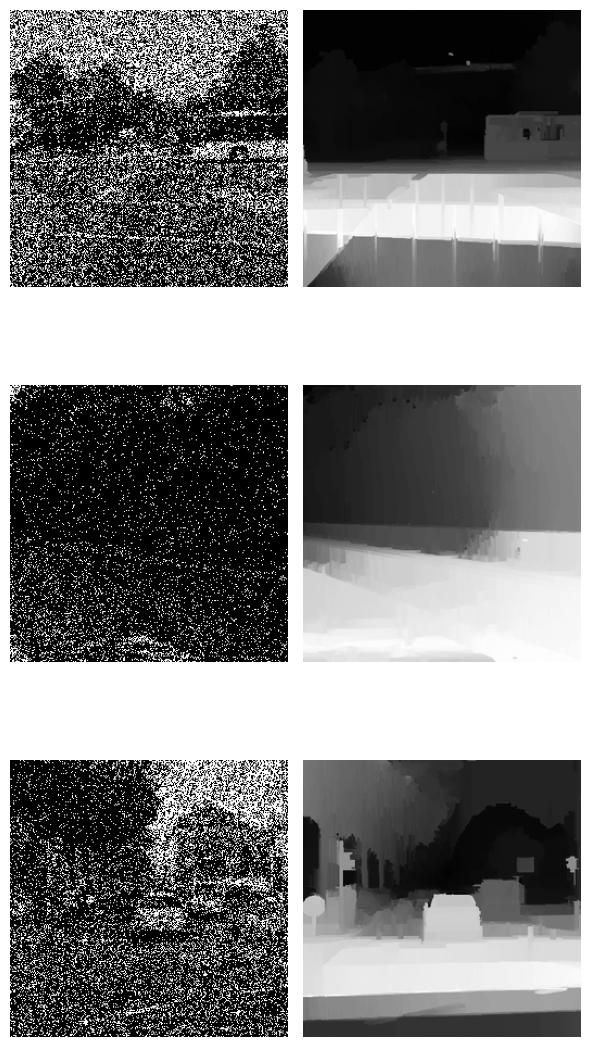

In [7]:
k = 3
utils.show_random_images(ds['train'],k=k, figsize=(k*2, k*4))

### Model and Other stafs

In [8]:
from importlib import reload
from models.unet import UNet
model = UNet(config)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
model(x)

[tensor([[[[-1.0947e+00, -4.1941e+00, -1.0500e+00,  ...,  9.0790e-01,
            -7.9813e-01, -3.9839e-01],
           [-2.0446e+00,  1.1914e+00,  1.4065e+00,  ..., -1.9941e+00,
            -2.1553e+00,  1.5940e+00],
           [-2.7345e+00, -7.8410e+00,  6.2809e-01,  ..., -6.8152e-01,
            -4.0387e+00, -2.2217e+00],
           ...,
           [-4.4712e+00,  2.2351e+00,  1.6515e-01,  ..., -2.2931e+00,
            -2.8256e+00,  9.3831e-01],
           [-2.4513e+00, -1.1178e+00,  1.2130e+00,  ..., -1.8508e+00,
             3.3473e-01, -1.2247e+00],
           [ 7.1202e-01,  2.1033e+00,  1.0348e+00,  ...,  2.7402e-01,
            -1.6227e+00, -5.1676e-01]]],
 
 
         [[[ 5.9049e-04, -1.2417e+00, -3.5116e+00,  ...,  1.5446e-01,
             1.5446e-01,  3.9069e-01],
           [-1.1139e+00,  3.2009e-02, -3.1698e+00,  ...,  8.6095e-01,
             8.6095e-01,  3.2026e-01],
           [ 1.3707e+00,  1.3872e+00, -3.4252e+00,  ...,  8.6095e-01,
             8.6095e-01,  3.2026e-01

In [12]:
import torch
from models import RMSELoss

#loss_fn = torch.nn.MSELoss()
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

### Training

In [13]:
from train2 import train
from datetime import datetime
if config['use_wandb']:
    run_name = type(model).__name__+str(datetime.now())[8:18]
    wandb.init(
        project=config['project'],
        name = run_name,
        config=config['model'],
    )
train(model, optimizer, loss_fn, dl, config, indices = [1,2,5,6,9], scheduler = scheduler, device = device, use_wandb=config['use_wandb'])

ModuleNotFoundError: No module named 'cv2'

### Predictions

In [ ]:
from tqdm import tqdm
import torch
import os
from torchvision.transforms.functional import to_pil_image
from datetime import datetime
from imgs2csv import images_to_csv_with_metadata
from train2 import predict


# def predict(model, dl, device='cpu', dest = 'predictions', use_wandb=False):
#     model.to(device)
#     model.eval()
#     os.makedirs('predictions', exist_ok=True)
#     model_name = type(model).__name__+'_'+str(datetime.now())[8:16]
#     save_dir = os.path.join('predictions',model_name)
#     print(save_dir)
#     os.makedirs(save_dir)
#     pbar = tqdm(dl,desc=f"Predicting.... ")
#     with torch.no_grad():
#         for i, (inputs, image_names) in enumerate(pbar):
#             inputs = inputs.to(device)
#             im_names = [s.split('/')[-1] for s in image_names]
#             outputs = model(inputs)
#             for x,name in zip(outputs, im_names):
#                 img = to_pil_image(x)
#                 img.save(os.path.join(save_dir, name))

#     images_to_csv_with_metadata(save_dir, 'predictions/pred_'+model_name+'.csv')
predict(model, dl['test'], model_config = config['model'], device = device, use_wandb=False)

Predicting.... :   0%|          | 0/84 [00:09<?, ?it/s]

torch.Size([1, 256, 256]) 18053611.png
